# Benchmark results Harpy

Below, we present figures illustrating the benchmark performance of Harpy.

We evaluate two representative workloads: (i) shallow feature extraction from multiplex images, defined here as the computation of mean intensities per instance, and (ii) the generation of single-cell representations from multiplex images.

The benchmarks were performed on a tonsil proteomics dataset acquired using the MACSima platform, and on a dataset acquired using the Merscope platform.

Both datasets were artificially enlarged: the tonsil dataset was tiled to 40 gigapixels, while the Merscope dataset was expanded to 1 terapixel. This was done to stress-test Harpy on two computationally demanding tasks typically run before downstream analysis.

The figures shown correspond to CPU-based execution. Note that Harpy also supports GPU acceleration via [`cupy`](https://cupy.dev/)
, which can provide additional speedups for large datasets.

Next, we focus on the gigapixel case (the 40‑gigapixel tonsil dataset) before moving to the terapixel benchmark.

## Gigapixel case

### Read the data:

In [2]:
import os
import tempfile

from spatialdata import read_zarr
import harpy as hp

sdata = hp.datasets.macsima_tonsil_benchmark()  # note this dataset is large (~100GB)
sdata.write(os.path.join(tempfile.gettempdir(), "sdata.zarr"), overwrite=True)
sdata = read_zarr(sdata.path)
sdata

/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_1_6_26/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


WARNING  Module 'bioio' is not installed. Install it with `pip install bioio` to use `harpy.io.macsima`.           
WARNING  Module 'bioio-ome-tiff' is not installed. Install it with `pip install bioio-ome-tiff` to use             
         `harpy.io.macsima`.                                                                                       


no parent found for <ome_zarr.reader.Label object at 0x7ff3ae727380>: None


SpatialData object
├── Images
│     ├── 'image_tiled': DataArray[cyx] (100, 20000, 20000)
│     └── 'image_tiled_dapi': DataTree[cyx] (1, 20000, 20000), (1, 10000, 10000), (1, 5000, 5000), (1, 2500, 2500), (1, 1250, 1250)
├── Labels
│     └── 'labels_cells_harpy': DataArray[yx] (20000, 20000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (206030, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        image_tiled (Images), image_tiled_dapi (Images), labels_cells_harpy (Labels), segmentation_mask_boundaries (Shapes)

This dataset contains 206,030 instances:

In [11]:
import dask.array as da

da.unique(sdata["labels_cells_harpy"].data).compute().shape  # the dataset contains 206030 instances

(206031,)

The image layer under the key "image_tiled" was obtained by artificially tiling the "ROI1_image" output of `harpy.datasets.macsima_tonsil()` into a 3D image layout with dimensions (c, y, x) = (100, 20000, 20000) ~40 giga-pixels.

The cell segmentation mask stored under the key "labels_cells_harpy" was generated using Cellpose (version 4) applied to the "image_tiled" image layer.

### Benchmark shallow feature extraction:

In [ ]:
from dask.distributed import Client, LocalCluster
from harpy.utils._aggregate import RasterAggregator

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="48GB",
)

client = Client(cluster)

img_layer = "image_tiled"
labels_layer = "labels_cells_harpy"

image = sdata[img_layer].data[:, None, ...]  # ( "c", "z", "y", "x" )
labels = sdata[labels_layer].data[None, ...]  # ( "z", "y", "x" )

aggregator = RasterAggregator(image_dask_array=image, mask_dask_array=labels)
dfs = aggregator.aggregate_stats(stats_funcs=("mean"))

client.close()

We varied the number of workers and obtained the following figures.

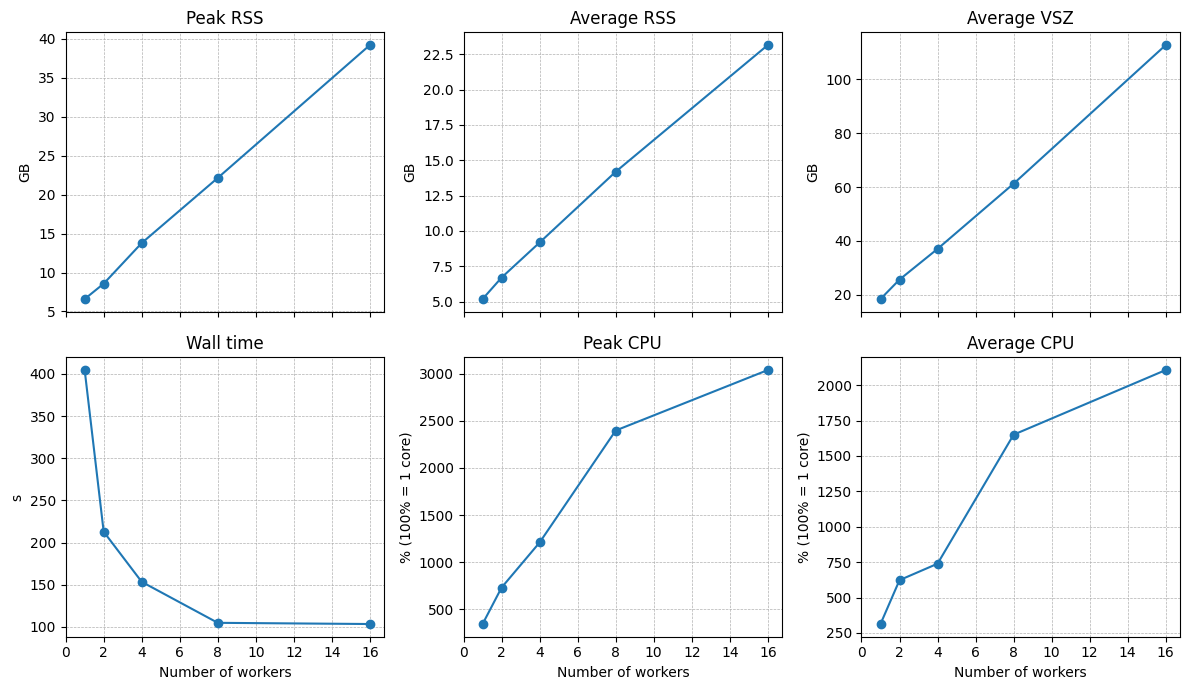

In [12]:
from IPython.display import Image, display

display(Image(filename="../figures/output_aggregate_mean.png"))

### Benchmark generation of single-cell representations from highly multiplexed images:

In [ ]:
import os

from dask.distributed import Client, LocalCluster

from tempfile import tempdir

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="48GB",
)

client = Client(cluster)

img_layer = "image_tiled"
labels_layer = "labels_cells_harpy"

instances_ids, instances = hp.tb.extract_instances(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    depth=100,
    diameter=50,
    batch_size=500,
    zarr_output_path=os.path.join(tempdir, "zarr_folder"),
    overwrite=True,
)

We varied the number of workers and obtained the following figures.

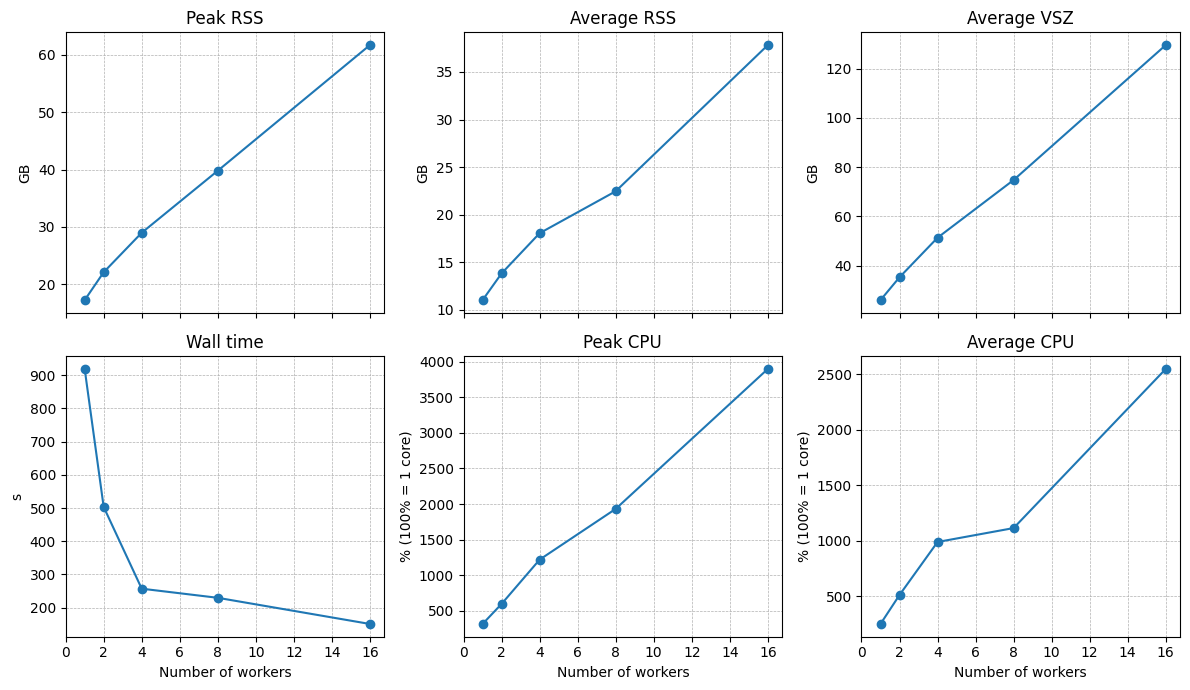

In [13]:
from IPython.display import Image, display

display(Image(filename="../figures/extract_instances.png"))

## Terapixel case

### Read the data:

In [ ]:
import os
import tempfile

from spatialdata import read_zarr
import harpy as hp

sdata = hp.datasets.merscope_mouse_liver_segmentation_mask()
sdata.write(os.path.join(tempfile.gettempdir(), "sdata.zarr"), overwrite=True)
sdata = read_zarr(sdata.path)

# artificially tile the data:

sdata = hp.im.add_image_layer(
    sdata,
    arr=da.tile(sdata["clahe"], (50, 1, 1)).rechunk((10, 2048, 2048)),  # Note this array is huge ~1.5TB
    output_layer="clahe_tiled",
    overwrite=True,
)

The image layer under the key "clahe_tiled" now has dimensions (c, y, x) = (100, 100000, 100000), totaling 1 terapixel (10¹² pixels).

The cell segmentation mask stored under the key "segmentation_mask_full" was generated using Cellpose (version 3) applied to the "clahe" image layer. The cell segmentation mask contains 278,482 instances.

### Benchmark shallow feature extraction:

In [ ]:
from dask.distributed import Client, LocalCluster
from harpy.utils._aggregate import RasterAggregator

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="243200MB",
    local_directory=os.environ.get("SCRATCHDIR") or os.environ.get("TMPDIR"),
)

client = Client(cluster)

img_layer = "segmentation_mask_full"
labels_layer = "clahe_tiled"

image = sdata[img_layer].data[:, None, ...]  # ( "c", "z", "y", "x" )
labels = sdata[labels_layer].data[None, ...]  # ( "z", "y", "x" )

aggregator = RasterAggregator(image_dask_array=image, mask_dask_array=labels)
dfs = aggregator.aggregate_stats(stats_funcs=("mean"))

client.close()

We varied the number of workers and obtained the following figures.

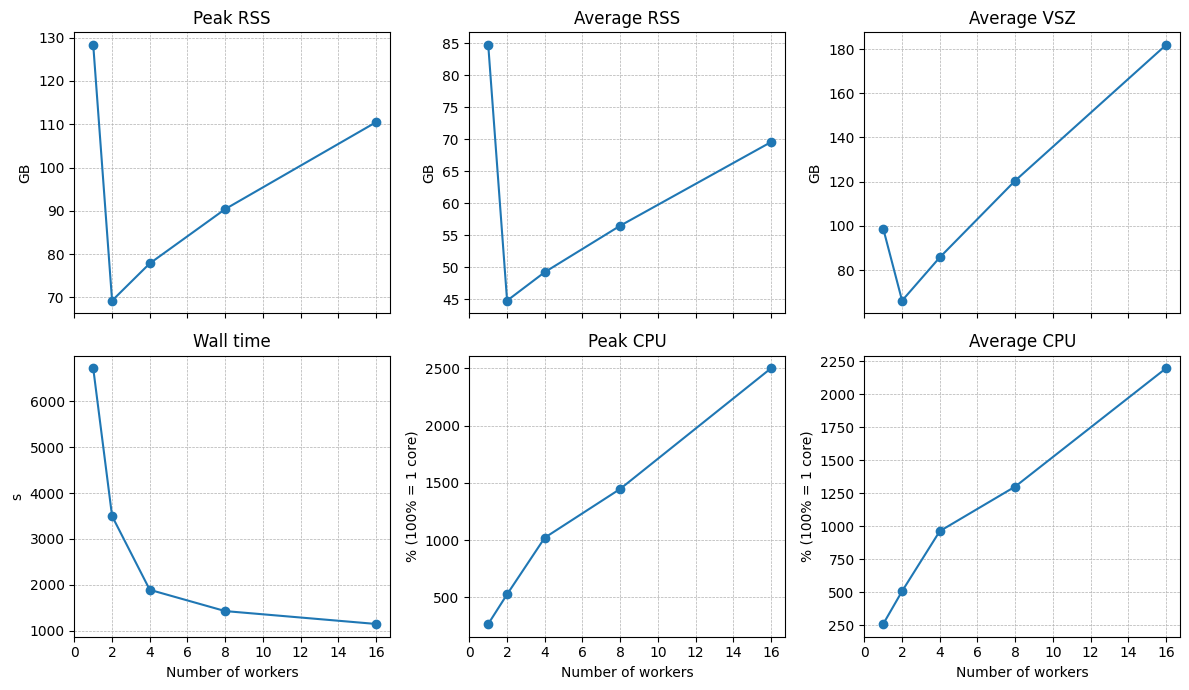

In [18]:
from IPython.display import Image, display

display(Image(filename="../figures/output_aggregate_mean_merscope.png"))

RSS (and VSZ) appears to spike at 1 worker, likely due to Dask holding onto chunks when parallelism is low.

### Benchmark generation of single-cell representations from highly multiplexed images:

In [ ]:
import os

from dask.distributed import Client, LocalCluster

from tempfile import tempdir

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="243200MB",
    local_directory=os.environ.get("SCRATCHDIR") or os.environ.get("TMPDIR"),
)

client = Client(cluster)

img_layer = "image_tiled"
labels_layer = "labels_cells_harpy"

instances_ids, instances = hp.tb.extract_instances(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    depth=200,
    diameter=100,
    batch_size=500,
    zarr_output_path=os.path.join(tempdir, "zarr_folder"),
    overwrite=True,
)

We varied the number of workers and obtained the following figures.

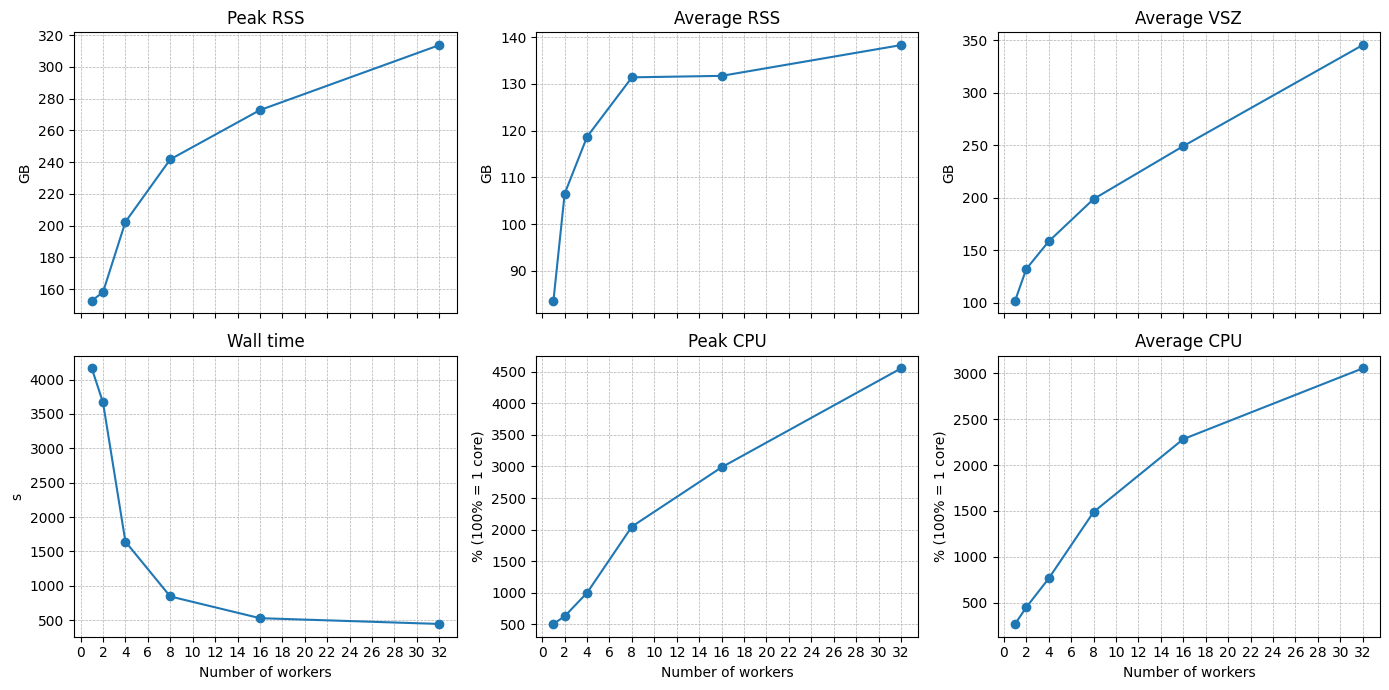

In [17]:
from IPython.display import Image, display

display(Image(filename="../figures/extract_instances_merscope.png"))